<a href="https://colab.research.google.com/github/AIGeek-Lover/Book-Finder-Emotion-Detector/blob/main/book_finder_emotion_detector.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Book Finder and Emotion Detector

This code is based on a freeCodeCamp tutorial (https://www.youtube.com/watch?v=Q7mS1VHm3Yw
), which uses a dataset by dylanjcastillo. In the original walkthrough, the author uses OpenAI’s embedding model. To experiment with an open-source alternative, I replaced it with MiniLM-L6-v2 from HuggingFace. For emotion detection, I used another open-source model: j-hartmann/emotion-english-distilroberta-base, which can also be downloaded directly from HuggingFace.

In [1]:
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt


In [2]:
import kagglehub

# Download latest version
path = kagglehub.dataset_download("dylanjcastillo/7k-books-with-metadata")

print("Path to dataset files:", path)

Using Colab cache for faster access to the '7k-books-with-metadata' dataset.
Path to dataset files: /kaggle/input/7k-books-with-metadata


### 1) Cleaning and analysing data

- Heatmap to determine missing Values
- Figure out how may books have missing description
- Analyse the corelation between missing books and the age of the book
- Dropping any rows and columns with missing variables
- Determine how short each description is
- Relating ISBN-13 (International Standard Book Number) to the description.

In [3]:
books = pd.read_csv(f"{path}/books.csv")
books.head()
books.describe()

,isbn13,published_year,average_rating,num_pages,ratings_count
count,6.810000e+03,6804.000000,6767.000000,6767.000000,6.767000e+03
mean,9.780677e+12,1998.630364,3.933284,348.181026,2.106910e+04
std,6.068911e+08,10.484257,0.331352,242.376783,1.376207e+05
min,9.780002e+12,1853.000000,0.000000,0.000000,0.000000e+00
25%,9.780330e+12,1996.000000,3.770000,208.000000,1.590000e+02
50%,9.780553e+12,2002.000000,3.960000,304.000000,1.018000e+03
75%,9.780810e+12,2005.000000,4.130000,420.000000,5.992500e+03
max,9.789042e+12,2019.000000,5.000000,3342.000000,5.629932e+06


- Produce a heatmap to determine which columns have missing values

  - The result shows subtitle has alot of missing values. It will not be useful to utilise that parameter for our model to find the optimum boof that particular request by the user. However , description has only a few missing parameters. It will be a useful parameter.


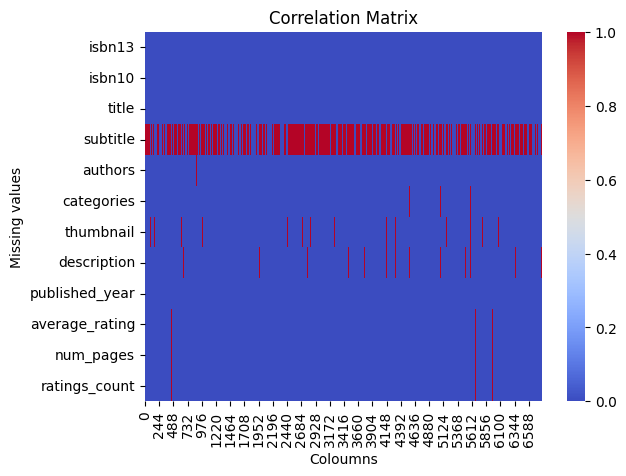

In [4]:
ax = plt.axes()
sns.heatmap(books.isna().transpose(),cbar = True,ax = ax , cmap = "coolwarm") # This shows which columns has nan values
ax.set_title("Correlation Matrix")
plt.xlabel("Coloumns")
plt.ylabel("Missing values")
plt.show()

- Figure out how may books have missing description




In [5]:
books["missing_description"] = books["description"].isna().astype(int) # if description is Na, will give 1
books["age_of_book"] = 2024 - books["published_year"]
books[["missing_description","age_of_book"]]

,missing_description,age_of_book
0,0,20.0
1,0,24.0
2,0,42.0
3,0,31.0
4,0,22.0
...,...,...
6805,0,25.0
6806,1,31.0
6807,1,20.0
6808,0,43.0


- Analyse the corelation between missing books and the age of the book


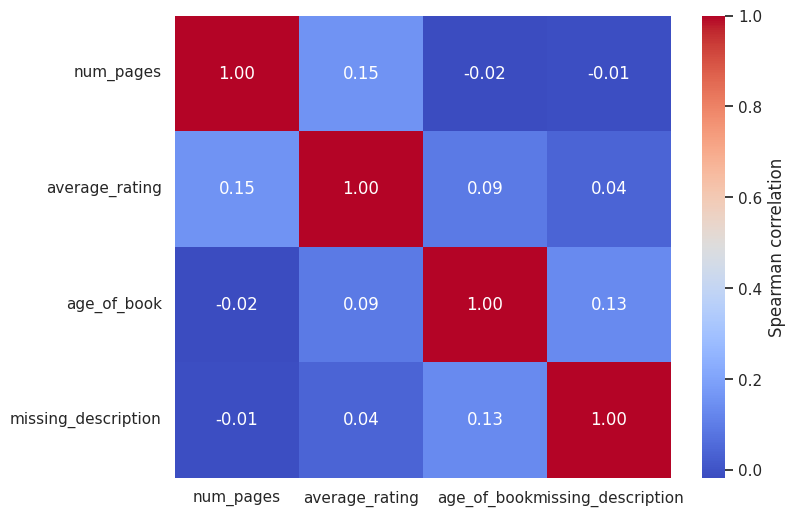

In [6]:
coloumns_of_interest = ["num_pages", "average_rating", "age_of_book", "missing_description"]
correlation_matrix = books[coloumns_of_interest].corr(method = "spearman") #pearson is for continuous values

sns.set_theme(style="white")
plt.figure(figsize=(8,6))
heatmap = sns.heatmap(correlation_matrix, annot =True, fmt = ".2f" , cmap = "coolwarm",cbar_kws ={"label":"Spearman correlation"})

In [7]:
#  shows data with Nan values
books[(books["description"].isna())|
     (books["num_pages"].isna()) |
     (books["average_rating"].isna())|
     (books["published_year"].isna()) ]

,isbn13,isbn10,title,subtitle,authors,categories,thumbnail,description,published_year,average_rating,num_pages,ratings_count,missing_description,age_of_book
37,9780006906018,000690601X,The Princess of the Chalet School,NaN,Elinor Mary Brent-Dyer,Juvenile Fiction,http://books.google.com/books/content?id=EJcQP...,NaN,2000.0,4.10,159.0,446.0,1,24.0
60,9780007127740,000712774X,The illustrated man,NaN,Ray Bradbury,Fiction,http://books.google.com/books/content?id=kePql...,NaN,2002.0,4.14,186.0,56781.0,1,22.0
99,9780020442806,0020442807,"The Chronicles of Narnia: Lion, the witch and ...",NaN,Clive Staples Lewis,Fairy tales,NaN,NaN,1978.0,4.26,1425.0,1446.0,1,46.0
102,9780023513206,0023513209,Reason in History,A General Introduction to the Philosophy of Hi...,Georg Wilhelm Friedrich Hegel,Philosophy,http://books.google.com/books/content?id=BCvcY...,NaN,1953.0,3.64,95.0,430.0,1,71.0
105,9780026995016,0026995018,Spandau,The Secret Diaries,Albert Speer,History,NaN,NaN,1976.0,4.12,463.0,6.0,1,48.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
6787,9783464371640,3464371646,About a Boy,NaN,Nick Hornby,NaN,http://books.google.com/books/content?id=PuDYw...,NaN,2002.0,3.80,256.0,155.0,1,22.0
6788,9783540292128,3540292128,Enzyme-Catalyzed Synthesis of Polymers,NaN,Shiro Kobayashi;Helmut Ritter;David Kaplan,Science,http://books.google.com/books/content?id=WXOym...,NaN,2006.0,0.00,254.0,0.0,1,18.0
6798,9787506435673,7506435675,Good Fight,NaN,Judd Winick;Matthew Clark,Juvenile Fiction,http://books.google.com/books/content?id=xGPZA...,Presents the adventures of a new group of hero...,2007.0,NaN,NaN,NaN,0,17.0
6806,9788185944609,8185944601,Secrets Of The Heart,NaN,Khalil Gibran,Mysticism,http://books.google.com/books/content?id=XcrVp...,NaN,1993.0,4.08,74.0,324.0,1,31.0


- Drops NA

In [8]:
# Creates new dataframe without Nan values (removes nan values)

books_clean = books[ ~(books["description"].isna()) &
       ~(books["num_pages"].isna()) &
       ~(books["average_rating"].isna())&
       ~(books["published_year"].isna()) ]



In [9]:

# Tells the count of a fiction in a descending order
books_clean["categories"].value_counts().reset_index().sort_values("count", ascending=False)

,categories,count
0,Fiction,2523
1,Juvenile Fiction,534
2,Biography & Autobiography,391
3,History,258
4,Literary Criticism,164
...,...,...
519,"Adventure stories, English",1
518,Germany,1
517,Egypt,1
516,Apartments,1


- Determine how short each description is





In [10]:
# We want to remove short descriptions or else it will not be meaningful.
# First we need to split the string and determine how many words there are
books_clean["words_in_description"] = books_clean["description"].str.split().str.len()
books_clean["words_in_description"]

/tmp/ipython-input-3224568246.py:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  books_clean["words_in_description"] = books_clean["description"].str.split().str.len()


,words_in_description
0,199
1,205
2,14
3,57
4,45
...,...
6803,63
6804,117
6805,174
6808,245


In [11]:
# if words in description is between 25 to 34 , it will show the description
books_clean.loc[books_clean["words_in_description"].between(25,34),"description"]


,description
9,Kate Blackwell is an enigma and one of the mos...
14,"Available in the U.S. for the first time, this..."
20,"It is 1937, and Charles Ashworth, a Canon to t..."
21,Reissue of the author's most famous and well-l...
46,No one believes a little girl when she insists...
...,...
6760,"Joel, an English teacher, has never really lik..."
6766,Discusses the historical and intellectual back...
6775,Presents nearly one thousand recipes--from app...
6779,Edited by the creator and executive producer o...


In [12]:
# removes description with less than 25 words
book_clean_25_words = books_clean[books_clean["words_in_description"] >= 25]

In [13]:
import numpy as np

In [14]:
# Joins title and subtitle with a semicolon
book_clean_25_words["title_and_subtitle"] = (np.where(book_clean_25_words["subtitle"].isna(),
                                              book_clean_25_words["title"],
                                              book_clean_25_words[["title" , "subtitle"]].astype(str).agg(": ".join,axis=1)))

/tmp/ipython-input-3917891843.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  book_clean_25_words["title_and_subtitle"] = (np.where(book_clean_25_words["subtitle"].isna(),


In [15]:
book_clean_25_words[["title_and_subtitle" ,"title" , "subtitle"]]

,title_and_subtitle,title,subtitle
0,Gilead,Gilead,NaN
1,Spider's Web: A Novel,Spider's Web,A Novel
3,Rage of angels,Rage of angels,NaN
4,The Four Loves,The Four Loves,NaN
5,The Problem of Pain,The Problem of Pain,NaN
...,...,...,...
6802,Mistaken Identity,Mistaken Identity,NaN
6803,Journey to the East,Journey to the East,NaN
6804,The Monk Who Sold His Ferrari: A Fable About F...,The Monk Who Sold His Ferrari: A Fable About F...,NaN
6805,I Am that: Talks with Sri Nisargadatta Maharaj,I Am that,Talks with Sri Nisargadatta Maharaj


- Relating ISBN-13 (International Standard Book Number) to the description.

In [16]:
# Need a unique tagged for vector search
book_clean_25_words["tagged_description"] = book_clean_25_words[["isbn13", "description"]].astype(str).agg(": ".join,axis=1)
book_clean_25_words[["tagged_description", "isbn13", "description"]]

/tmp/ipython-input-3473112968.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  book_clean_25_words["tagged_description"] = book_clean_25_words[["isbn13", "description"]].astype(str).agg(": ".join,axis=1)


,tagged_description,isbn13,description
0,9780002005883: A NOVEL THAT READERS and critic...,9780002005883,A NOVEL THAT READERS and critics have been eag...
1,9780002261982: A new 'Christie for Christmas' ...,9780002261982,A new 'Christie for Christmas' -- a full-lengt...
3,"9780006178736: A memorable, mesmerizing heroin...",9780006178736,"A memorable, mesmerizing heroine Jennifer -- b..."
4,9780006280897: Lewis' work on the nature of lo...,9780006280897,Lewis' work on the nature of love divides love...
5,"9780006280934: ""In The Problem of Pain, C.S. L...",9780006280934,"""In The Problem of Pain, C.S. Lewis, one of th..."
...,...,...,...
6802,9788172235222: On A Train Journey Home To Nort...,9788172235222,On A Train Journey Home To North India After L...
6803,9788173031014: This book tells the tale of a m...,9788173031014,This book tells the tale of a man who goes on ...
6804,9788179921623: Wisdom to Create a Life of Pass...,9788179921623,"Wisdom to Create a Life of Passion, Purpose, a..."
6805,9788185300535: This collection of the timeless...,9788185300535,This collection of the timeless teachings of o...


In [17]:
book_clean_25_words.drop([ "age_of_book", "words_in_description"], axis =1).to_csv("books_cleaned.csv",index = False)

In [18]:
book_clean_25_words

,isbn13,isbn10,title,subtitle,authors,categories,thumbnail,description,published_year,average_rating,num_pages,ratings_count,missing_description,age_of_book,words_in_description,title_and_subtitle,tagged_description
0,9780002005883,0002005883,Gilead,NaN,Marilynne Robinson,Fiction,http://books.google.com/books/content?id=KQZCP...,A NOVEL THAT READERS and critics have been eag...,2004.0,3.85,247.0,361.0,0,20.0,199,Gilead,9780002005883: A NOVEL THAT READERS and critic...
1,9780002261982,0002261987,Spider's Web,A Novel,Charles Osborne;Agatha Christie,Detective and mystery stories,http://books.google.com/books/content?id=gA5GP...,A new 'Christie for Christmas' -- a full-lengt...,2000.0,3.83,241.0,5164.0,0,24.0,205,Spider's Web: A Novel,9780002261982: A new 'Christie for Christmas' ...
3,9780006178736,0006178731,Rage of angels,NaN,Sidney Sheldon,Fiction,http://books.google.com/books/content?id=FKo2T...,"A memorable, mesmerizing heroine Jennifer -- b...",1993.0,3.93,512.0,29532.0,0,31.0,57,Rage of angels,"9780006178736: A memorable, mesmerizing heroin..."
4,9780006280897,0006280897,The Four Loves,NaN,Clive Staples Lewis,Christian life,http://books.google.com/books/content?id=XhQ5X...,Lewis' work on the nature of love divides love...,2002.0,4.15,170.0,33684.0,0,22.0,45,The Four Loves,9780006280897: Lewis' work on the nature of lo...
5,9780006280934,0006280935,The Problem of Pain,NaN,Clive Staples Lewis,Christian life,http://books.google.com/books/content?id=Kk-uV...,"""In The Problem of Pain, C.S. Lewis, one of th...",2002.0,4.09,176.0,37569.0,0,22.0,75,The Problem of Pain,"9780006280934: ""In The Problem of Pain, C.S. L..."
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
6802,9788172235222,8172235224,Mistaken Identity,NaN,Nayantara Sahgal,Indic fiction (English),http://books.google.com/books/content?id=q-tKP...,On A Train Journey Home To North India After L...,2003.0,2.93,324.0,0.0,0,21.0,288,Mistaken Identity,9788172235222: On A Train Journey Home To Nort...
6803,9788173031014,8173031010,Journey to the East,NaN,Hermann Hesse,Adventure stories,http://books.google.com/books/content?id=rq6JP...,This book tells the tale of a man who goes on ...,2002.0,3.70,175.0,24.0,0,22.0,63,Journey to the East,9788173031014: This book tells the tale of a m...
6804,9788179921623,817992162X,The Monk Who Sold His Ferrari: A Fable About F...,NaN,Robin Sharma,Health & Fitness,http://books.google.com/books/content?id=c_7mf...,"Wisdom to Create a Life of Passion, Purpose, a...",2003.0,3.82,198.0,1568.0,0,21.0,117,The Monk Who Sold His Ferrari: A Fable About F...,9788179921623: Wisdom to Create a Life of Pass...
6805,9788185300535,8185300534,I Am that,Talks with Sri Nisargadatta Maharaj,Sri Nisargadatta Maharaj;Sudhakar S. Dikshit,Philosophy,http://books.google.com/books/content?id=Fv_JP...,This collection of the timeless teachings of o...,1999.0,4.51,531.0,104.0,0,25.0,174,I Am that: Talks with Sri Nisargadatta Maharaj,9788185300535: This collection of the timeless...


### 2) Vector Search

Turns text into vector representations and predicts what the word before and after is. Thats what a Encoder does. Transformers either contain Encoder or Decoder or BOTH. Decoder basically provides the output after the vector is run through the input.




In [19]:

!pip install langchain langchain-community langchain-openai langchain-chroma chromadb


In [20]:
from langchain_community.document_loaders import TextLoader  # 📄 Loads text files as documents
from langchain_text_splitters import CharacterTextSplitter   # ✂️ Splits long documents into smaller chunks (by character count)
from langchain_chroma import Chroma                          # 🗃️ Stores and searches vector embeddings using Chroma (a vector database)
from langchain_community.embeddings import HuggingFaceEmbeddings


In [21]:
data = pd.read_csv("books_cleaned.csv")



In [22]:
# We need to save it in text file since langchain is unable to read it
data["tagged_description"].to_csv("tagged_description.txt", sep = "\n", index = False , header = False)


In [23]:
# Now we going to load the text in using  langchain
raw_documents = TextLoader("tagged_description.txt").load()

# We are going to split the long documents
text_splitter = CharacterTextSplitter(
    chunk_size=100,          # 🚫 Not splitting anything (0 means no chunks)
    chunk_overlap=0,        # 📏 No overlap between chunks
    separator="\n"          # 🔪 Split on newline character
)
documents = text_splitter.split_documents(raw_documents) # initializes the text splitter from above

Streaming output truncated to the last 5000 lines.


In [24]:
documents[0] # check whether the text splitter works

Document(metadata={'source': 'tagged_description.txt'}, page_content='9780002005883: A NOVEL THAT READERS and critics have been eagerly anticipating for over a decade, Gilead is an astonishingly imagined story of remarkable lives. John Ames is a preacher, the son of a preacher and the grandson (both maternal and paternal) of preachers. It’s 1956 in Gilead, Iowa, towards the end of the Reverend Ames’s life, and he is absorbed in recording his family’s story, a legacy for the young son he will never see grow up. Haunted by his grandfather’s presence, John tells of the rift between his grandfather and his father: the elder, an angry visionary who fought for the abolitionist cause, and his son, an ardent pacifist. He is troubled, too, by his prodigal namesake, Jack (John Ames) Boughton, his best friend’s lost son who returns to Gilead searching for forgiveness and redemption. Told in John Ames’s joyous, rambling voice that finds beauty, humour and truth in the smallest of life’s details, G

### Loading the  Model

#### The model we are going to load is MiniLM ( its only a encoder) to extract the best book based on users recommnedation

In [25]:
embedding_model = HuggingFaceEmbeddings(model_name="sentence-transformers/all-MiniLM-L6-v2")
db_books = Chroma.from_documents(documents, embedding=embedding_model)

/tmp/ipython-input-518499915.py:1: LangChainDeprecationWarning: The class `HuggingFaceEmbeddings` was deprecated in LangChain 0.2.2 and will be removed in 1.0. An updated version of the class exists in the `langchain-huggingface package and should be used instead. To use it run `pip install -U `langchain-huggingface` and import as `from `langchain_huggingface import HuggingFaceEmbeddings``.
  embedding_model = HuggingFaceEmbeddings(model_name="sentence-transformers/all-MiniLM-L6-v2")
/usr/local/lib/python3.12/dist-packages/huggingface_hub/utils/_auth.py:104: UserWarning: 
Error while fetching `HF_TOKEN` secret value from your vault: 'Requesting secret HF_TOKEN timed out. Secrets can only be fetched when running from the Colab UI.'.
You are not authenticated with the Hugging Face Hub in this notebook.
If the error persists, please let us know by opening an issue on GitHub (https://github.com/huggingface/huggingface_hub/issues/new).
  warnings.warn(


modules.json:   0%|          | 0.00/349 [00:00<?, ?B/s]

config_sentence_transformers.json:   0%|          | 0.00/116 [00:00<?, ?B/s]

README.md: 0.00B [00:00, ?B/s]

sentence_bert_config.json:   0%|          | 0.00/53.0 [00:00<?, ?B/s]

config.json:   0%|          | 0.00/612 [00:00<?, ?B/s]

model.safetensors:   0%|          | 0.00/90.9M [00:00<?, ?B/s]

tokenizer_config.json:   0%|          | 0.00/350 [00:00<?, ?B/s]

vocab.txt: 0.00B [00:00, ?B/s]

tokenizer.json: 0.00B [00:00, ?B/s]

special_tokens_map.json:   0%|          | 0.00/112 [00:00<?, ?B/s]

config.json:   0%|          | 0.00/190 [00:00<?, ?B/s]

#### Second Model is a fine tuning model used to determine emotion of a sentence. The model will be trained on the descriptions of the book returned by the previous model

In [26]:
from transformers import pipeline
classifier = pipeline("text-classification", model="j-hartmann/emotion-english-distilroberta-base", top_k =None,  return_all_scores=True)


config.json: 0.00B [00:00, ?B/s]

pytorch_model.bin:   0%|          | 0.00/329M [00:00<?, ?B/s]

tokenizer_config.json:   0%|          | 0.00/294 [00:00<?, ?B/s]

model.safetensors:   0%|          | 0.00/329M [00:00<?, ?B/s]

vocab.json: 0.00B [00:00, ?B/s]

merges.txt: 0.00B [00:00, ?B/s]

tokenizer.json: 0.00B [00:00, ?B/s]

special_tokens_map.json:   0%|          | 0.00/239 [00:00<?, ?B/s]

Device set to use cuda:0


### Gradio  UI

We are going to use Gradio UI

In [27]:
import gradio as gr

# Your models and DB are already loaded
# db_books: VectorStore or FAISS DB for book descriptions
# classifier: Hugging Face zero-shot or emotion classification pipeline

def find_book_and_emotion(query):
    # Step 1: Search for the best matching book using the first model
    # the docs returns the description of the book which is stored in a pandasfram
    docs = db_books.similarity_search(query, k=1)
    if not docs:
        return "❌ No matching book found."

    # The Second model only requires a string and the main content of the answer of the previous model.
    book = docs[0]
    book_text = book.page_content
    source = book.metadata.get("source", "Unknown")

    # Step 2: Run emotion classifier on the book description
    predictions = classifier(book_text)
    top_label = max(predictions[0], key=lambda x: x['score'])

    # Output string
    result = f"📖 **Book Match:** {book_text}\n\n"
    result += f"📘 **Source:** {source}\n"
    result += f"❤️ **Detected Emotion:** {top_label['label'].capitalize()} (Score: {top_label['score']:.2f})"
    return result

# Gradio app
gr.Interface(
    fn=find_book_and_emotion,
    inputs=gr.Textbox(label="Describe the type of book you want to read"),
    outputs=gr.Markdown(label="Matched Book and Emotion"),
    title="📚 Book Finder + Emotion Detector",
    description="Enter a description (e.g. 'a story about friendship and war') and get the best matching book and its emotional tone."
).launch()


It looks like you are running Gradio on a hosted Jupyter notebook, which requires `share=True`. Automatically setting `share=True` (you can turn this off by setting `share=False` in `launch()` explicitly).

Colab notebook detected. To show errors in colab notebook, set debug=True in launch()
* Running on public URL: https://a6f9071b2b07461abf.gradio.live

This share link expires in 1 week. For free permanent hosting and GPU upgrades, run `gradio deploy` from the terminal in the working directory to deploy to Hugging Face Spaces (https://huggingface.co/spaces)
